# Disease Informed Neural Networks Tests

In [88]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time

In [89]:
class Neural_net(torch.nn.Module):
    def __init__(self, n_in = 1, n_out =1):
        super(Neural_net, self).__init__()

        self.tanh = torch.nn.Tanh()

        self.layer1 = torch.nn.Linear(n_in,20)
        self.layer2 = torch.nn.Linear(20,20)
        self.layer3 = torch.nn.Linear(20,20)
        self.layer_out = torch.nn.Linear(20,n_out)

    def forward(self, x):
        x = self.layer1(x)
        x = self.tanh(x)
        x = self.layer2(x)
        x = self.tanh(x)
        x = self.layer3(x)
        x = self.tanh(x)
        x = self.layer_out(x)

        return x

In [147]:
class sir_pinn:
    def __init__(self, epochs, data, c0, nde = 100):
        self.epochs = epochs
        self.model = Neural_net(n_out=3)
        self.domain = torch.linspace(0,int(max(data[0])),nde, requires_grad=True).reshape(-1,1)
        
        
        # self.beta_unconstr = torch.nn.Parameter(torch.randn(1))
        # self.gamma_unconstr = torch.nn.Parameter(torch.randn(1))

        self.beta_unconstr = torch.nn.Parameter(torch.tensor([0.1], dtype=torch.float))
        self.gamma_unconstr = torch.nn.Parameter(torch.tensor([0.1], dtype=torch.float))


        # Adding gamma and alpha to model trainable variables
        self.model.register_parameter(name='beta', param = self.beta_unconstr)
        self.model.register_parameter(name='gamma', param = self.gamma_unconstr)
        self.lbfgs_optimizer = torch.optim.LBFGS(params = self.model.parameters(), lr = 0.001,max_iter = 500)
        self.adam_optimizer = torch.optim.Adam(params = self.model.parameters(), lr = 0.0001)

       
        self.t_dat = torch.Tensor(data[0]).reshape(-1,1)
        self.S_dat = torch.Tensor(data[1])
        self.I_dat = torch.Tensor(data[2])
        self.R_dat = torch.Tensor(data[3])

        #find values for normalization

        self.maxes = {}
        self.mins = {}

        for id,d in enumerate((self.S_dat, self.I_dat, self.R_dat)):
            self.maxes[id] = max(d)
            self.mins[id] = min(d)

        self.N = self.maxes[0]
    
        #normalize
        self.S_norm = self.normalize(0, self.S_dat)
        self.I_norm = self.normalize(1, self.I_dat)
        self.R_norm = self.normalize(2, self.R_dat)

        #self.c0 = torch.tensor([max(self.S_norm), min(self.I_norm), min(self.R_norm)])
        self.c0 = torch.tensor([self.normalize(0, c0[0]), self.normalize(1, c0[1]),  self.normalize(2,c0[2])])
                

    #Constrain parameters to be in range
    @property
    def beta(self):
        return torch.tanh(self.beta_unconstr)
    
    @property
    def gamma(self):
        return torch.tanh(self.gamma_unconstr)
    
    def wrap_grad(self, f,x):
        return torch.autograd.grad(f,x,
        grad_outputs=torch.ones_like(x),
        retain_graph=True,
        create_graph=True)[0]
    

    def normalize(self, id, unnormed):
        return (unnormed - self.mins[id])/(self.maxes[id]- self.mins[id])

    def un_normalize(self, id, normed):
        return normed*(self.maxes[id] -self.mins[id])+ self.mins[id]

        
    def de_loss(self):
        pred = self.model(self.domain)
        S, I, R = (x.reshape(-1,1) for x in torch.unbind(pred, dim =1))
        
        dsir_dict ={}
        for id, val in zip(('dS', 'dI', 'dR'),(S, I, R)):
            dsir_dict[id] = self.wrap_grad(val.reshape(-1,1), self.domain)
        
        dS, dI, dR = dsir_dict.values()

        ic = torch.mean((pred[0] - self.c0)**2)
        S = self.un_normalize(0, S) # un-normalizing, necessary for calcuclating derivative
        I = self.un_normalize(1, I)  
        R = self.un_normalize(2, R)

        z1 = dS + ((self.beta / self.N) * S * I)  / (self.maxes[0] - self.mins[0]) # Rescaling derivatives want d(norm(s))
        z2 = dI - ((self.beta / self.N) * S * I - self.gamma * I) / (self.maxes[1] - self.mins[1])
        z3 = dR - (self.gamma * I ) / (self.maxes[2] - self.mins[2])
        
        return torch.mean(z1**2) + torch.mean(z2**2) +torch.mean(z3**2) + ic
    
    def data_loss(self):
        S, I, R =  torch.unbind(self.model(self.t_dat), dim =1)
        z1 = torch.mean((self.S_norm - S)**2)
        z2 = torch.mean((self.I_norm - I)**2)
        z3 = torch.mean((self.R_norm - R)**2)
        return z1 + z2 + z3

    def combined_loss(self):
        return self.de_loss() + self.data_loss()    
    
    def model_call(self):
        return self.model(self.domain)
    
    def plot_preds(self):
        S,I,R = torch.unbind(self.model(self.domain), dim =1)
        S = self.un_normalize(0, S) 
        I = self.un_normalize(1, I)  
        R = self.un_normalize(2, R)
        plt.plot(self.domain.detach(), S.detach(), label = 's_pred')
        plt.plot(self.domain.detach(), I.detach(), label = 'i_pred')
        plt.plot(self.domain.detach(), R.detach(), label = 'r_pred')
        plt.scatter(self.t_dat, self.S_dat, label = 's_true')
        plt.scatter(self.t_dat, self.I_dat, label ='i_true' )
        plt.scatter(self.t_dat, self.R_dat, label ='r_true' )
        plt.grid()
        plt.legend()
    

    def lbfgs_train(self):
            self.model.train()    
            for epoch in range(self.epochs):
                def closure():
                    self.lbfgs_optimizer.zero_grad()
                    loss = self.combined_loss()
                    loss.backward()
                    return loss
                self.lbfgs_optimizer.step(closure=closure)
                print(f'Epoch {epoch}, training loss: {self.combined_loss()}, beta_param: {self.beta}, gamma_param: {self.gamma}')
            self.plot_preds()
    

    def adam_train(self):
            steps = 1000
            self.model.train()
            for epoch in range(self.epochs):
                for step in range(steps):
                    def closure():
                        self.adam_optimizer.zero_grad()
                        loss = self.combined_loss()
                        loss.backward()
                        return loss
                    self.adam_optimizer.step(closure=closure)
                print(f'Epoch {epoch}, training loss: {self.combined_loss()}, beta_param: {self.beta}, gamma_param: {self.gamma}')
            self.plot_preds()

In [148]:
class sir_pinn_fixed_p(sir_pinn):
    """ Subclass of SIR pinn to solve without data.
    """
    def __init__(self, epochs, data, c0, beta, gamma):
        super().__init__(epochs, data, c0)

        self.beta_fixed = beta
        self.gamma_fixed = gamma
        
    
    def de_loss(self):
        pred = self.model(self.domain)
        S, I, R = (x.reshape(-1,1) for x in torch.unbind(pred, dim =1))
        
        dsir_dict ={}
        for id, val in zip(('dS', 'dI', 'dR'),(S, I, R)):
            dsir_dict[id] = self.wrap_grad(val.reshape(-1,1), self.domain)
        
        dS, dI, dR = dsir_dict.values()

        ic = torch.mean((pred[:2] - self.c0)**2)
        S = self.un_normalize(0, S) # un-normalizing, necessary for calcuclating derivative
        I = self.un_normalize(1, I)  
        R = self.un_normalize(2, R)

        z1 = dS + ((self.beta_fixed / self.N) * S * I)  / (self.maxes[0] - self.mins[0]) # Rescaling derivatives want d(norm(s))
        z2 = dI - ((self.beta_fixed / self.N) * S * I - self.gamma_fixed * I) / (self.maxes[1] - self.mins[1])
        z3 = dR - (self.gamma_fixed * I ) / (self.maxes[2] - self.mins[2])
        
        return torch.mean(z1**2) + torch.mean(z2**2) +torch.mean(z3**2) + ic
    
    def combined_loss(self):
        return self.de_loss()
    
    def plot_preds(self):
        S,I,R = torch.unbind(self.model(self.domain), dim =1)
        S = self.un_normalize(0, S) 
        I = self.un_normalize(1, I)  
        R = self.un_normalize(2, R)
        plt.plot(self.domain.detach(), S.detach(), label = 's_pred')
        plt.plot(self.domain.detach(), I.detach(), label = 'i_pred')
        plt.plot(self.domain.detach(), R.detach(), label = 'r_pred')
        # plt.scatter(self.t_dat, self.S_dat, label = 's_true')
        # plt.scatter(self.t_dat, self.I_dat, label ='i_true' )
        # plt.scatter(self.t_dat, self.R_dat, label ='r_true' )
        plt.grid()
        plt.legend()
    
    def adam_train(self):
            steps = 1000
            self.model.train()
            for epoch in range(self.epochs):
                for step in range(steps):
                    def closure():
                        self.adam_optimizer.zero_grad()
                        loss = self.combined_loss()
                        loss.backward()
                        return loss
                    self.adam_optimizer.step(closure=closure)
                print(f'Epoch {epoch}, training loss: {self.combined_loss()}')
            self.plot_preds()

In [149]:
class sir_neural_net(sir_pinn):
    """ Subclass of SIR pinn to solve without de-loss.
    So as a normal NN model... 

    """
    def __init__(self, epochs, data, c0):
        super().__init__(epochs, data, c0)
    
    def combined_loss(self):
        return self.data_loss()
    
    def plot_preds(self):
        S,I,R = torch.unbind(self.model(self.domain), dim =1)
        S = self.un_normalize(0, S) 
        I = self.un_normalize(1, I)  
        R = self.un_normalize(2, R)
        plt.plot(self.domain.detach(), S.detach(), label = 's_pred')
        plt.plot(self.domain.detach(), I.detach(), label = 'i_pred')
        plt.plot(self.domain.detach(), R.detach(), label = 'r_pred')
        plt.scatter(self.t_dat, self.S_dat, label = 's_true')
        plt.scatter(self.t_dat, self.I_dat, label ='i_true' )
        plt.scatter(self.t_dat, self.R_dat, label ='r_true' )
        plt.grid()
        plt.legend()
    
    def adam_train(self):
            steps = 1000
            self.model.train()
            for epoch in range(self.epochs):
                for step in range(steps):
                    def closure():
                        self.adam_optimizer.zero_grad()
                        loss = self.combined_loss()
                        loss.backward()
                        return loss
                    self.adam_optimizer.step(closure=closure)
                print(f'Epoch {epoch}, training loss: {self.combined_loss()}')
            self.plot_preds()
    

Retrieving Data

In [150]:
#raisi_data = genfromtxt('../Gitfolder/DINN/COVID_Tutorial.csv', delimiter=',') #in the form of [t,S,I,D,R]

b005_g002_i001 = genfromtxt('Data/SIR_generated/b005_g002_i001', delimiter=',').T #1
b005_g002_i050 = genfromtxt('Data/SIR_generated/b005_g002_i050', delimiter=',').T #2
b050_g005_i050 = genfromtxt('Data/SIR_generated/b050_g005_i050', delimiter=',').T #3
b070_g016_i001 = genfromtxt('Data/SIR_generated/b070_g016_i001', delimiter=',').T #4
b070_g016_i020 = genfromtxt('Data/SIR_generated/b070_g016_i020', delimiter=',').T #5

In [151]:
def sampling(data, size= 200):
    ids = np.random.choice(range(data.shape[1]),size = size)
    sample_data = data[:,ids]
    traind, testd = (sample_data[:,:-sample_data.shape[1]//2], sample_data[:,sample_data.shape[1]//2:])
    return traind, testd

In [152]:
b005_g002_i001_train, b005_g002_i001_test = sampling(b005_g002_i001)
b005_g002_i050_train, b005_g002_i050_test = sampling(b005_g002_i050)
b050_g005_i050_train, b050_g005_i050_test = sampling(b050_g005_i050)
b070_g016_i001_train, b070_g016_i001_test = sampling(b070_g016_i001)
b070_g016_i020_train, b070_g016_i020_test = sampling(b070_g016_i020) 

In [153]:
b005_g002_i001_C0 = b005_g002_i001[1:][:,0]
b005_g002_i050_C0 = b005_g002_i050[1:][:,0]
b050_g005_i050_C0 = b050_g005_i050[1:][:,0]
b070_g016_i001_C0 = b070_g016_i001[1:][:,0]
b070_g016_i020_C0 = b070_g016_i020[1:][:,0]

In [154]:
def test_loss(inst, test_data):
    """ computes MSE over test data
    """
    t = torch.Tensor(test_data[0]).reshape(-1,1)
    S = inst.normalize(0,torch.Tensor(test_data[1]))
    I = inst.normalize(1, torch.Tensor(test_data[2]))
    R = inst.normalize(2, torch.Tensor(test_data[3]))
    
    s_pred, i_pred, r_pred = torch.unbind(inst.model(t), dim =1)

    z0 = torch.mean((S-s_pred)**2)
    z1 = torch.mean((I-i_pred)**2)
    z2 = torch.mean((R-r_pred)**2)

    return z0 + z1 + z2


### Testing scheme:

Have generated 5 sets of simulation data of varying underlying parameters $\beta, \gamma$ and varying $(I_0, S_0)$.  $R_0$ always assumed to be zero. 

Want to compare the performance of: 
 
 
    ~ "Many" datapoints and "many" de-domain points.            Hypothesis: Performs well, can be considered best possible model.
  
    ~ "Few" datapoints and "many" de-domain points.             Hypothesis: Should also perform "well", 
  
    ~ "Few" datapoints only                                     Hypothesis: Should perform "worse" than the two above
  
    ~ "Many" de-domaion points only, and fixed parameters       Hypothesis: Should be problematic: difficult to fit properly
 
 
    (~ maybe also: only "few de-domain points", and fixed params) Hypotheis:  Also difficult?
 
    (~ Try "few" data-points "many" domain points for real-world covid data) Hypothesis: Will find some parameter. 

(Note: DE-domain: t points used when calculating differential equation loss under training)

For each of these models the following metrics shall be recorded: 
     
    10k steps (10 epochs, 1000 steps) training accuracy 
    10k steps test accuracy: MSE.
    Save10k plot

    TUS (Train Until Satisfied) - training accuracy MSE
    TUS - Test accuracy MSE
    Save TUS plot.



#  Round 1

Parameters:
N = 1,

I0 = 0.01,

S0= 0.99 

$\beta$ = 0.05
$\gamma$ = 0.02


sir-pinn instance naming scheme, examples: 
    
    r1_da100_de100 = Round 1,  100 datapoints, 100 de-domain points. 
    
    r1_da010_de100 =Round 1, 10 datapoints, 100 de-domain-points

    r1_da010_de000 = you get it

    


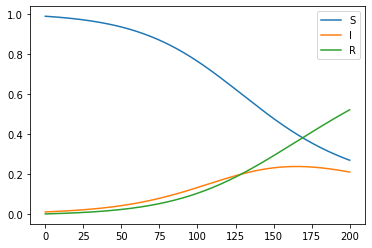

In [102]:
# Plot of true solution
plt.plot(b005_g002_i001[0], b005_g002_i001[1], label = 'S')
plt.plot(b005_g002_i001[0], b005_g002_i001[2], label = 'I')
plt.plot(b005_g002_i001[0], b005_g002_i001[3], label = 'R')
plt.legend()

In [12]:
r1_da100_de100 = sir_pinn(epochs=10,data= b005_g002_i001_train, c0 = b005_g002_i001_C0)
r1_da010_de100 = sir_pinn(epochs=10,data= b005_g002_i001_train[:,:10], c0 = b005_g002_i001_C0) # _train variabels are randomly selected
r1_da010_de000 = sir_neural_net(epochs=10,data= b005_g002_i001_train[:,:10], c0 = b005_g002_i001_C0)
r1_da000_de100 = sir_pinn_fixed_p(epochs=10, data= b005_g002_i001_train, c0 =b005_g002_i001_C0, beta = 0.05, gamma=0.02)


### R1 "Many" datapoints and "many" de-domain points.

###### r1_da100_de100 10 epochs Run #######
Epoch 0, training loss: 0.12718577682971954, beta_param: tensor([-0.8934], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.4904], grad_fn=<TanhBackward0>)
Epoch 1, training loss: 0.04970577359199524, beta_param: tensor([-0.8721], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.3915], grad_fn=<TanhBackward0>)
Epoch 2, training loss: 0.04065889120101929, beta_param: tensor([-0.8401], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.3380], grad_fn=<TanhBackward0>)
Epoch 3, training loss: 0.03607583045959473, beta_param: tensor([-0.8011], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.3127], grad_fn=<TanhBackward0>)
Epoch 4, training loss: 0.03141244873404503, beta_param: tensor([-0.7553], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.2948], grad_fn=<TanhBackward0>)
Epoch 5, training loss: 0.025311097502708435, beta_param: tensor([-0.7015], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.2779], grad_fn=<TanhBackward0>)
Epoch 6, trai

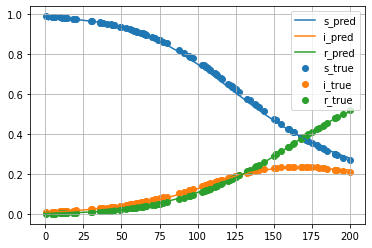

In [13]:
print('###### r1_da100_de100 10 epochs Run #######')
r1_da100_de100.adam_train()
print(f'Test loss {test_loss(r1_da100_de100,b005_g002_i001_test)}')

###### r1_da100_de100 TUS Run #######
Epoch 0, training loss: 0.006346195004880428, beta_param: tensor([-0.3337], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.1382], grad_fn=<TanhBackward0>)
Epoch 1, training loss: 0.003953388426452875, beta_param: tensor([-0.2511], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.1047], grad_fn=<TanhBackward0>)
Epoch 2, training loss: 0.0021652188152074814, beta_param: tensor([-0.1717], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.0721], grad_fn=<TanhBackward0>)
Epoch 3, training loss: 0.0009882004233077168, beta_param: tensor([-0.0990], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.0420], grad_fn=<TanhBackward0>)
Epoch 4, training loss: 0.0003474586410447955, beta_param: tensor([-0.0369], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.0161], grad_fn=<TanhBackward0>)
Epoch 5, training loss: 8.097603131318465e-05, beta_param: tensor([0.0098], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0034], grad_fn=<TanhBackward0>)
Epoch 6, tra

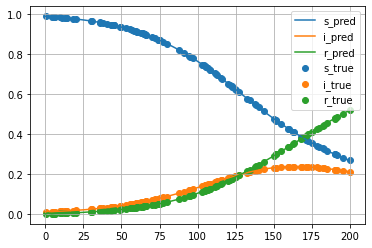

In [14]:
# Note, To get TUS values, run cell until satisfied
print('###### r1_da100_de100 TUS Run #######') 
r1_da100_de100.adam_train()
print(f'Test loss {test_loss(r1_da100_de100,b005_g002_i001_test)}')

### R1 "Few" datapoints and "many" de-domain points.

###### r1_da010_de100 10 epochs Run #######
Epoch 0, training loss: 0.5203348398208618, beta_param: tensor([-0.8641], grad_fn=<TanhBackward0>), gamma_param: tensor([0.1413], grad_fn=<TanhBackward0>)
Epoch 1, training loss: 0.1336260586977005, beta_param: tensor([-0.8346], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0384], grad_fn=<TanhBackward0>)
Epoch 2, training loss: 0.08611248433589935, beta_param: tensor([-0.8016], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.0529], grad_fn=<TanhBackward0>)
Epoch 3, training loss: 0.0619010329246521, beta_param: tensor([-0.7628], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.1299], grad_fn=<TanhBackward0>)
Epoch 4, training loss: 0.04559880495071411, beta_param: tensor([-0.7179], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.1938], grad_fn=<TanhBackward0>)
Epoch 5, training loss: 0.03547458350658417, beta_param: tensor([-0.6686], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.2399], grad_fn=<TanhBackward0>)
Epoch 6, training l

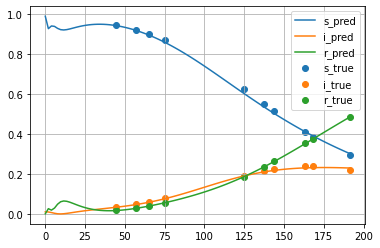

In [15]:
print('###### r1_da010_de100 10 epochs Run #######')
r1_da010_de100.adam_train()
print(f'Test loss {test_loss(r1_da010_de100,b005_g002_i001_test)}')

###### r1_da010_de100 TUS Run #######
Epoch 0, training loss: 0.008163992315530777, beta_param: tensor([-0.3277], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.1514], grad_fn=<TanhBackward0>)
Epoch 1, training loss: 0.004975260701030493, beta_param: tensor([-0.2461], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.1136], grad_fn=<TanhBackward0>)
Epoch 2, training loss: 0.002695344854146242, beta_param: tensor([-0.1672], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.0776], grad_fn=<TanhBackward0>)
Epoch 3, training loss: 0.001204668777063489, beta_param: tensor([-0.0946], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.0447], grad_fn=<TanhBackward0>)
Epoch 4, training loss: 0.0003964977222494781, beta_param: tensor([-0.0328], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.0166], grad_fn=<TanhBackward0>)
Epoch 5, training loss: 8.299560431623831e-05, beta_param: tensor([0.0126], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0041], grad_fn=<TanhBackward0>)
Epoch 6, train

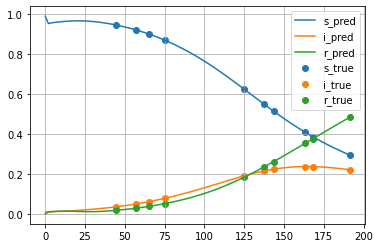

In [16]:
# To get TUS values, run cell until satisfied
print('###### r1_da010_de100 TUS Run #######') 
r1_da010_de100.adam_train()
print(f'Test loss {test_loss(r1_da010_de100,b005_g002_i001_test)}')

### R1 "Few" datapoints only 

###### r1_da010_de000 10 epochs Run #######
Epoch 0, training loss: 0.09858091175556183
Epoch 1, training loss: 0.03639094531536102
Epoch 2, training loss: 0.013504204340279102
Epoch 3, training loss: 0.006095523945987225
Epoch 4, training loss: 0.004638041835278273
Epoch 5, training loss: 0.004020189866423607
Epoch 6, training loss: 0.0033158513251692057
Epoch 7, training loss: 0.0021874206140637398
Epoch 8, training loss: 0.000648673449177295
Epoch 9, training loss: 0.0001257378316950053
Test loss 0.023445671424269676


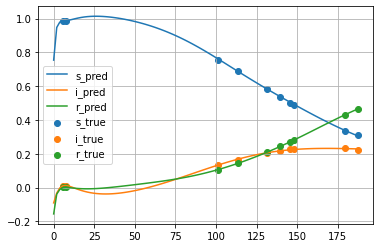

In [13]:
print('###### r1_da010_de000 10 epochs Run #######')
r1_da010_de000.adam_train()
print(f'Test loss {test_loss(r1_da010_de000,b005_g002_i001_test)}')

###### r1_da010_de000 TUS Run #######
Epoch 0, training loss: 6.943195671738067e-07
Epoch 1, training loss: 6.536607770613045e-07
Epoch 2, training loss: 6.167523451949819e-07
Epoch 3, training loss: 5.851028390679858e-07
Epoch 4, training loss: 5.514401664186153e-07
Epoch 5, training loss: 5.226210646469553e-07
Epoch 6, training loss: 3.751008534891298e-06
Epoch 7, training loss: 4.7236773070835625e-07
Epoch 8, training loss: 1.14668432615872e-06
Epoch 9, training loss: 4.300422915548552e-07
Test loss 0.0022644237615168095


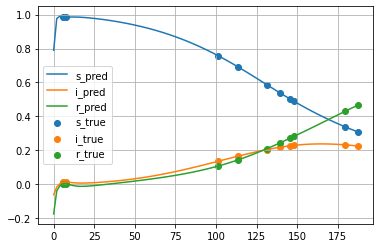

In [16]:
print('###### r1_da010_de000 TUS Run #######')
r1_da010_de000.adam_train()
print(f'Test loss {test_loss(r1_da010_de000,b005_g002_i001_test)}')

### R1 "Many" de-domain points only, and fixed parameters 

###### r1_da000_de100 10 epochs Run #######
Epoch 0, training loss: 0.0004339060396887362
Epoch 1, training loss: 0.00034766667522490025
Epoch 2, training loss: 0.000255373161053285
Epoch 3, training loss: 0.0001655749510973692
Epoch 4, training loss: 9.162731294054538e-05
Epoch 5, training loss: 3.9821472455514595e-05
Epoch 6, training loss: 1.1332271242281422e-05
Epoch 7, training loss: 2.453186652928707e-06
Epoch 8, training loss: 1.1875707741637598e-06
Epoch 9, training loss: 9.519029617877095e-07
Test loss 0.73039710521698


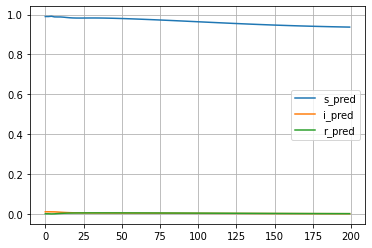

In [19]:
print('###### r1_da000_de100 10 epochs Run #######')
r1_da000_de100.adam_train()
print(f'Test loss {test_loss(r1_da000_de100,b005_g002_i001_test)}')

###### r1_da000_de100 TUS Run #######
Epoch 0, training loss: 8.458204092676169e-07
Epoch 1, training loss: 8.015611570044712e-07
Epoch 2, training loss: 7.633688596797583e-07
Epoch 3, training loss: 7.354762487921107e-07
Epoch 4, training loss: 7.156049832701683e-07
Epoch 5, training loss: 6.987683036641101e-07
Epoch 6, training loss: 6.848354701105563e-07
Epoch 7, training loss: 6.743413223375683e-07
Epoch 8, training loss: 6.631966584791371e-07
Epoch 9, training loss: 6.553213438564853e-07
Test loss 0.7568109035491943


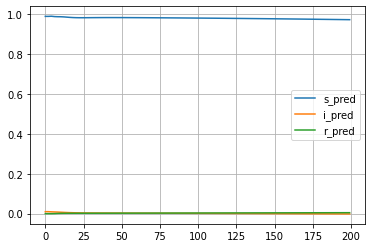

In [20]:
print('###### r1_da000_de100 TUS Run #######')
r1_da000_de100.adam_train()
print(f'Test loss {test_loss(r1_da000_de100,b005_g002_i001_test)}')

#  Round 2

Parameters:
N = 1,

I0 = 0.5,
S0= 0.5

$\beta$ = 0.05
$\gamma$ = 0.02

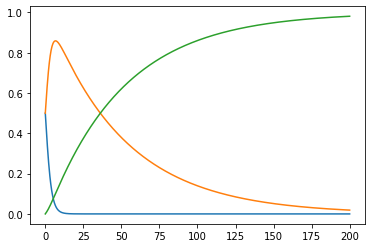

In [110]:
### True solution plot

plt.plot(b005_g002_i050[0], b005_g002_i050[1])
plt.plot(b005_g002_i050[0], b005_g002_i050[2])
plt.plot(b005_g002_i050[0], b005_g002_i050[3])


In [155]:
r2_da100_de100 = sir_pinn(epochs=10,data= b005_g002_i050_train, c0 = b005_g002_i050_C0)
r2_da010_de100 = sir_pinn(epochs=10,data= b005_g002_i050_train[:,:10], c0 = b005_g002_i050_C0) 
r2_da010_de000 = sir_neural_net(epochs=10,data= b005_g002_i050_train[:,:10], c0 = b005_g002_i050_C0)
r2_da000_de100 = sir_pinn_fixed_p(epochs=10, data= b005_g002_i050_train, c0 =b005_g002_i050_C0, beta = 0.05, gamma=0.02)

### R2 "Many" datapoints and "many" de-domain points.

###### r2_da100_de100 10 epochs Run #######
Epoch 0, training loss: 0.08295893669128418, beta_param: tensor([0.1866], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0316], grad_fn=<TanhBackward0>)
Epoch 1, training loss: 0.0016436788719147444, beta_param: tensor([0.2091], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0211], grad_fn=<TanhBackward0>)
Epoch 2, training loss: 0.000512962113134563, beta_param: tensor([0.2011], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0191], grad_fn=<TanhBackward0>)
Epoch 3, training loss: 0.00028169184224680066, beta_param: tensor([0.2000], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0190], grad_fn=<TanhBackward0>)
Epoch 4, training loss: 0.00015747957513667643, beta_param: tensor([0.2046], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0192], grad_fn=<TanhBackward0>)
Epoch 5, training loss: 7.639007526449859e-05, beta_param: tensor([0.2097], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0194], grad_fn=<TanhBackward0>)
Epoch 6, traini

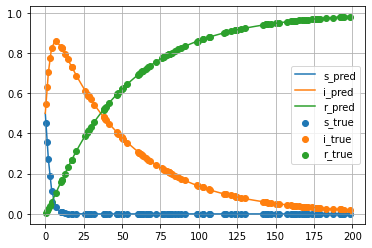

In [156]:
print('###### r2_da100_de100 10 epochs Run #######')
r2_da100_de100.adam_train()
print(f'Test loss {test_loss(r2_da100_de100,b005_g002_i050_test)}')

###### r2_da100_de100 TUS Run #######
Epoch 0, training loss: 7.640697958777309e-07, beta_param: tensor([0.2237], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0200], grad_fn=<TanhBackward0>)
Epoch 1, training loss: 6.915713584021432e-07, beta_param: tensor([0.2238], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0200], grad_fn=<TanhBackward0>)
Epoch 2, training loss: 1.3246469734440325e-06, beta_param: tensor([0.2238], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0200], grad_fn=<TanhBackward0>)
Epoch 3, training loss: 5.983454798297316e-07, beta_param: tensor([0.2239], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0200], grad_fn=<TanhBackward0>)
Epoch 4, training loss: 5.745488351749373e-07, beta_param: tensor([0.2239], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0200], grad_fn=<TanhBackward0>)
Epoch 5, training loss: 5.552694801735925e-07, beta_param: tensor([0.2240], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0200], grad_fn=<TanhBackward0>)
Epoch 6, training l

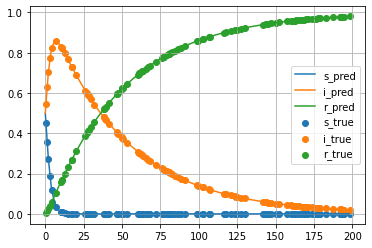

In [158]:
print('###### r2_da100_de100 TUS Run #######') 
r2_da100_de100.adam_train()
print(f'Test loss {test_loss(r2_da100_de100,b005_g002_i050_test)}')

### R2 "Few" datapoints and "many" de-domain points.

###### r2_da010_de100 10 epochs Run #######
Epoch 0, training loss: 6710.71240234375, beta_param: tensor([0.0007], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0301], grad_fn=<TanhBackward0>)
Epoch 1, training loss: 6469.83349609375, beta_param: tensor([0.0005], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0275], grad_fn=<TanhBackward0>)
Epoch 2, training loss: 6267.14794921875, beta_param: tensor([0.0006], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0268], grad_fn=<TanhBackward0>)
Epoch 3, training loss: 6075.07568359375, beta_param: tensor([0.0006], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0257], grad_fn=<TanhBackward0>)
Epoch 4, training loss: 5888.4794921875, beta_param: tensor([0.0007], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0168], grad_fn=<TanhBackward0>)
Epoch 5, training loss: 5705.8798828125, beta_param: tensor([0.0006], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0129], grad_fn=<TanhBackward0>)
Epoch 6, training loss: 5526.64892578125, beta

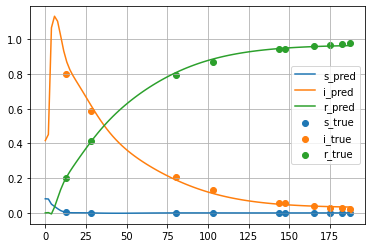

In [159]:
print('###### r2_da010_de100 10 epochs Run #######')
r2_da010_de100.adam_train()
print(f'Test loss {test_loss(r2_da010_de100,b005_g002_i050_test)}')

###### r2_da010_de100 TUS Run #######
Epoch 0, training loss: 1158.87890625, beta_param: tensor([3.1555e-06], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0238], grad_fn=<TanhBackward0>)
Epoch 1, training loss: 1080.4490966796875, beta_param: tensor([4.7305e-06], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0238], grad_fn=<TanhBackward0>)
Epoch 2, training loss: 1005.03955078125, beta_param: tensor([-4.2518e-07], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0237], grad_fn=<TanhBackward0>)
Epoch 3, training loss: 932.3572387695312, beta_param: tensor([1.3287e-06], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0237], grad_fn=<TanhBackward0>)
Epoch 4, training loss: 862.40283203125, beta_param: tensor([3.5441e-06], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0236], grad_fn=<TanhBackward0>)
Epoch 5, training loss: 795.372802734375, beta_param: tensor([2.4868e-06], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0236], grad_fn=<TanhBackward0>)
Epoch 6, training loss: 73

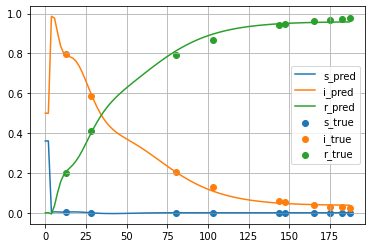

In [163]:
print('###### r2_da010_de100 TUS Run #######') 
r2_da010_de100.adam_train()
print(f'Test loss {test_loss(r2_da010_de100,b005_g002_i050_test)}')

### R2 "Few" datapoints only 

###### r2_da010_de000 10 epochs Run #######
Epoch 0, training loss: 0.05163120478391647
Epoch 1, training loss: 0.02235674485564232
Epoch 2, training loss: 0.002182490425184369
Epoch 3, training loss: 0.00021306109556462616
Epoch 4, training loss: 8.713226998224854e-05
Epoch 5, training loss: 4.884210284217261e-05
Epoch 6, training loss: 3.339203976793215e-05
Epoch 7, training loss: 2.479334216332063e-05
Epoch 8, training loss: 1.720348882372491e-05
Epoch 9, training loss: 1.0906082025030628e-05
Test loss 536.449462890625


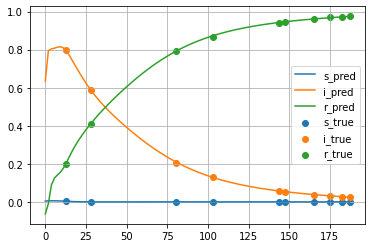

In [164]:
print('###### r2_da010_de000 10 epochs Run #######')
r2_da010_de000.adam_train()
print(f'Test loss {test_loss(r2_da010_de000,b005_g002_i050_test)}')

###### r2_da010_de000 TUS Run #######
Epoch 0, training loss: 6.8151834966556635e-06
Epoch 1, training loss: 6.727399977535242e-06
Epoch 2, training loss: 3.2790758268674836e-06
Epoch 3, training loss: 2.809794295899337e-06
Epoch 4, training loss: 2.0638854039134458e-06
Epoch 5, training loss: 1.7327402019873261e-06
Epoch 6, training loss: 1.3733824744122103e-06
Epoch 7, training loss: 1.1101426480308874e-06
Epoch 8, training loss: 8.885742772690719e-07
Epoch 9, training loss: 6.980664579714357e-07
Test loss 534.7293701171875


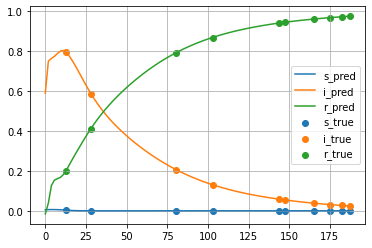

In [165]:
print('###### r2_da010_de000 TUS Run #######')
r2_da010_de000.adam_train()
print(f'Test loss {test_loss(r2_da010_de000,b005_g002_i050_test)}')

### R2 "Many" de-domain points only, and fixed parameters 

###### r2_da000_de100 10 epochs Run #######
Epoch 0, training loss: 0.0007903214427642524
Epoch 1, training loss: 0.0006312872865237296
Epoch 2, training loss: 0.0004946116823703051
Epoch 3, training loss: 0.0003784427244681865
Epoch 4, training loss: 0.00028762785950675607
Epoch 5, training loss: 0.00021892026416026056
Epoch 6, training loss: 0.00016780613805167377
Epoch 7, training loss: 0.00012934149708598852
Epoch 8, training loss: 9.840639540925622e-05
Epoch 9, training loss: 6.733266491210088e-05
Test loss 0.45221075415611267


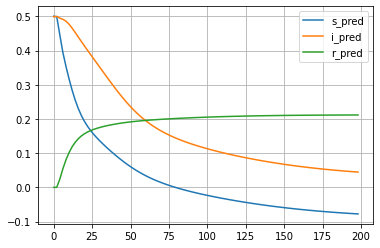

In [166]:
print('###### r2_da000_de100 10 epochs Run #######')
r2_da000_de100.adam_train()
print(f'Test loss {test_loss(r2_da000_de100,b005_g002_i050_test)}')

###### r2_da000_de100 TUS Run #######
Epoch 0, training loss: 2.6817685849778172e-08
Epoch 1, training loss: 1.2578415464759019e-07
Epoch 2, training loss: 2.471689519722986e-08
Epoch 3, training loss: 2.4103153251076037e-08
Epoch 4, training loss: 2.292060230502102e-08
Epoch 5, training loss: 2.3413171845731995e-08
Epoch 6, training loss: 2.13512496571866e-08
Epoch 7, training loss: 2.062252058010472e-08
Epoch 8, training loss: 3.30888134669749e-08
Epoch 9, training loss: 1.0909853642715461e-07
Test loss 0.04206528514623642


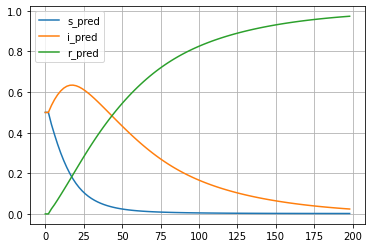

In [170]:
print('###### r2_da000_de100 TUS Run #######')
r2_da000_de100.adam_train()
print(f'Test loss {test_loss(r2_da000_de100,b005_g002_i050_test)}')

#  Round 3

Parameters:

N = 1,

I0 = 0.50,

S0= 0.50 

$\beta$ = 0.50
$\gamma$ = 0.05



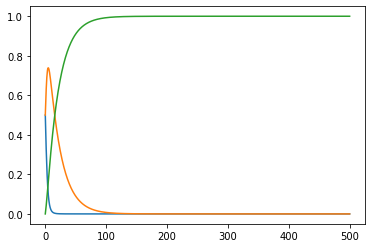

In [31]:
#Plot of true solution
plt.plot(b050_g005_i050[0], b050_g005_i050[1])
plt.plot(b050_g005_i050[0], b050_g005_i050[2])
plt.plot(b050_g005_i050[0], b050_g005_i050[3])


In [18]:
r3_da100_de100 = sir_pinn(epochs=10,data= b005_g002_i050_train, c0 = b050_g005_i050_C0)
r3_da010_de100 = sir_pinn(epochs=10,data= b005_g002_i050_train[:,:10], c0 = b050_g005_i050_C0) 
r3_da010_de000 = sir_neural_net(epochs=10,data= b005_g002_i050_train[:,:10], c0 = b050_g005_i050_C0)
r3_da000_de100 = sir_pinn_fixed_p(epochs=10, data= b005_g002_i050_train, c0 =b050_g005_i050_C0, beta = 0.50, gamma=0.05)

### R3 "Many" datapoints and "many" de-domain points.

###### r3_da100_de100 10 epochs Run #######
Epoch 0, training loss: 0.08754611760377884, beta_param: tensor([-0.2114], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.0234], grad_fn=<TanhBackward0>)
Epoch 1, training loss: 0.017045531421899796, beta_param: tensor([-0.0966], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0014], grad_fn=<TanhBackward0>)
Epoch 2, training loss: 0.004964399617165327, beta_param: tensor([-0.0147], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0193], grad_fn=<TanhBackward0>)
Epoch 3, training loss: 0.0015482062008231878, beta_param: tensor([0.0363], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0319], grad_fn=<TanhBackward0>)
Epoch 4, training loss: 0.0006955540738999844, beta_param: tensor([0.0609], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0380], grad_fn=<TanhBackward0>)
Epoch 5, training loss: 0.0003376081585884094, beta_param: tensor([0.0713], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0407], grad_fn=<TanhBackward0>)
Epoch 6, train

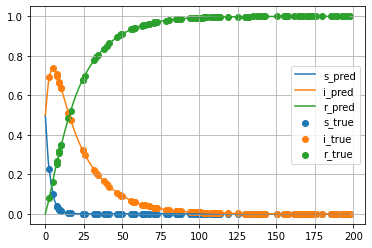

In [33]:
print('###### r3_da100_de100 10 epochs Run #######')
r3_da100_de100.adam_train()
print(f'Test loss {test_loss(r3_da100_de100,b050_g005_i050_test)}')

###### r3_da100_de100 TUS Run #######
Epoch 0, training loss: 3.6744467024618643e-07, beta_param: tensor([0.1124], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0500], grad_fn=<TanhBackward0>)
Epoch 1, training loss: 7.66394691709138e-07, beta_param: tensor([0.1124], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0500], grad_fn=<TanhBackward0>)
Epoch 2, training loss: 3.3839907587207563e-07, beta_param: tensor([0.1124], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0500], grad_fn=<TanhBackward0>)
Epoch 3, training loss: 4.473792216685979e-07, beta_param: tensor([0.1124], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0500], grad_fn=<TanhBackward0>)
Epoch 4, training loss: 3.5066295822616667e-07, beta_param: tensor([0.1124], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0500], grad_fn=<TanhBackward0>)
Epoch 5, training loss: 3.017334222477075e-07, beta_param: tensor([0.1124], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0500], grad_fn=<TanhBackward0>)
Epoch 6, training 

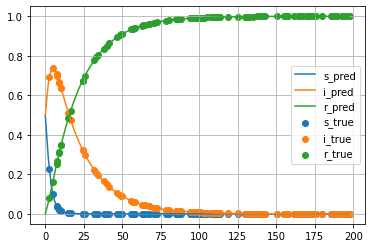

In [74]:
print('###### r3_da100_de100 TUS Run #######') 
r3_da100_de100.adam_train()
print(f'Test loss {test_loss(r3_da100_de100,b050_g005_i050_test)}')

### R3 "Few" datapoints and "many" de-domain points.

###### r3_da010_de100 10 epochs Run #######
Epoch 0, training loss: 0.10796582698822021, beta_param: tensor([0.6843], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.3405], grad_fn=<TanhBackward0>)
Epoch 1, training loss: 0.02104700542986393, beta_param: tensor([0.6212], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.2384], grad_fn=<TanhBackward0>)
Epoch 2, training loss: 0.006962533108890057, beta_param: tensor([0.5784], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.1402], grad_fn=<TanhBackward0>)
Epoch 3, training loss: 0.0030136308632791042, beta_param: tensor([0.5387], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.0622], grad_fn=<TanhBackward0>)
Epoch 4, training loss: 0.0012079671723768115, beta_param: tensor([0.4967], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.0025], grad_fn=<TanhBackward0>)
Epoch 5, training loss: 0.0005152065423317254, beta_param: tensor([0.4514], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0368], grad_fn=<TanhBackward0>)
Epoch 6, train

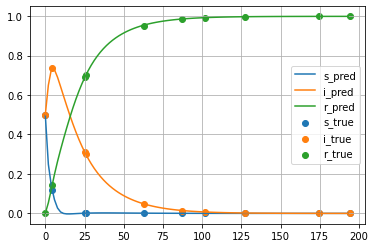

In [94]:
print('###### r3_da010_de100 10 epochs Run #######')
r3_da010_de100.adam_train()
print(f'Test loss {test_loss(r3_da010_de100,b050_g005_i050_test)}')

###### r3_da010_de100 TUS Run #######
Epoch 0, training loss: 2.8289142051107774e-07, beta_param: tensor([0.2512], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0499], grad_fn=<TanhBackward0>)
Epoch 1, training loss: 8.912291349361112e-08, beta_param: tensor([0.2511], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0499], grad_fn=<TanhBackward0>)
Epoch 2, training loss: 2.5825369220910943e-07, beta_param: tensor([0.2510], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0499], grad_fn=<TanhBackward0>)
Epoch 3, training loss: 7.661942902359442e-08, beta_param: tensor([0.2509], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0499], grad_fn=<TanhBackward0>)
Epoch 4, training loss: 9.697454572688002e-08, beta_param: tensor([0.2509], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0499], grad_fn=<TanhBackward0>)
Epoch 5, training loss: 6.392409801492249e-08, beta_param: tensor([0.2508], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0499], grad_fn=<TanhBackward0>)
Epoch 6, training 

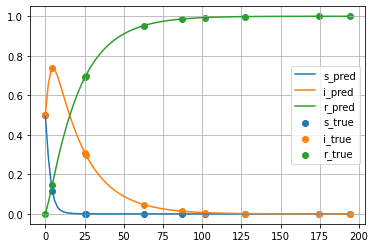

In [96]:
print('###### r3_da010_de100 TUS Run #######') 
r3_da010_de100.adam_train()
print(f'Test loss {test_loss(r3_da010_de100,b050_g005_i050_test)}')

### R3 "Few" datapoints only 

###### r3_da010_de000 10 epochs Run #######
Epoch 0, training loss: 0.0386052131652832
Epoch 1, training loss: 0.0002463834243826568
Epoch 2, training loss: 0.0001021848656819202
Epoch 3, training loss: 3.506736538838595e-05
Epoch 4, training loss: 1.6316822438966483e-05
Epoch 5, training loss: 8.13490532891592e-06
Epoch 6, training loss: 3.547458618413657e-06
Epoch 7, training loss: 3.1459824185731122e-06
Epoch 8, training loss: 2.993188672917313e-06
Epoch 9, training loss: 2.757469701464288e-06
Test loss 4.793211701326072e-05


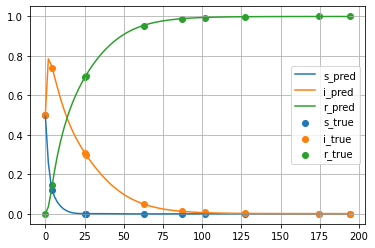

In [99]:
print('###### r3_da010_de000 10 epochs Run #######')
r3_da010_de000.adam_train()
print(f'Test loss {test_loss(r3_da010_de000,b050_g005_i050_test)}')

###### r3_da010_de000 TUS Run #######
Epoch 0, training loss: 8.448664630122948e-06
Epoch 1, training loss: 4.583141617331421e-06
Epoch 2, training loss: 6.702335213049082e-06
Epoch 3, training loss: 1.084966925191111e-06
Epoch 4, training loss: 5.070555175734626e-07
Epoch 5, training loss: 2.7837586458190344e-07
Epoch 6, training loss: 1.8857500663216342e-06
Epoch 7, training loss: 3.765867973015702e-07
Epoch 8, training loss: 2.878363858371813e-08
Epoch 9, training loss: 9.982995408108764e-08
Test loss 1228.576904296875


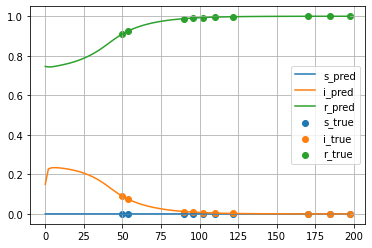

In [21]:
print('###### r3_da010_de000 TUS Run #######')
r3_da010_de000.adam_train()
print(f'Test loss {test_loss(r3_da010_de000,b050_g005_i050_test)}')

### R3 "Many" de-domain points only, and fixed parameters 

###### r3_da000_de100 10 epochs Run #######
Epoch 0, training loss: 0.07457704097032547
Epoch 1, training loss: 0.06916696578264236
Epoch 2, training loss: 0.0672420859336853
Epoch 3, training loss: 0.0643390417098999
Epoch 4, training loss: 0.048937030136585236
Epoch 5, training loss: 0.03512546420097351
Epoch 6, training loss: 0.003886396996676922
Epoch 7, training loss: 0.00016302491712849587
Epoch 8, training loss: 0.00010255701636197045
Epoch 9, training loss: 6.186607060953975e-05
Test loss 0.5884406566619873


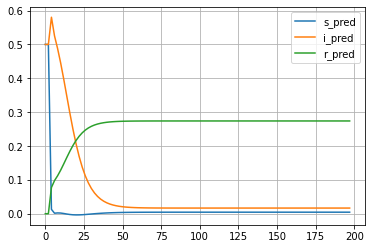

In [39]:
print('###### r3_da000_de100 10 epochs Run #######')
r3_da000_de100.adam_train()
print(f'Test loss {test_loss(r3_da000_de100,b050_g005_i050_test)}')

###### r3_da000_de100 TUS Run #######
Epoch 0, training loss: 3.7477970181498677e-05
Epoch 1, training loss: 2.0132269128225744e-05
Epoch 2, training loss: 4.88130126541364e-06
Epoch 3, training loss: 3.130234063064563e-06
Epoch 4, training loss: 2.4954802029242273e-06
Epoch 5, training loss: 1.6259770063697943e-06
Epoch 6, training loss: 1.3723021083933418e-06
Epoch 7, training loss: 1.831370468607929e-06
Epoch 8, training loss: 1.0566744776951964e-06
Epoch 9, training loss: 9.428505336472881e-07
Test loss 0.0697324350476265


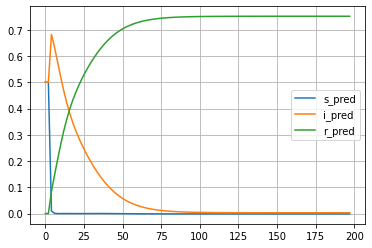

In [40]:
print('###### r3_da000_de100 TUS Run #######')
r3_da000_de100.adam_train()
print(f'Test loss {test_loss(r3_da000_de100,b050_g005_i050_test)}')

#  Round 4

Parameters:

N = 1,

I0 = 0.01,

S0= 0.99 

$\beta$ = 0.70
$\gamma$ = 0.16


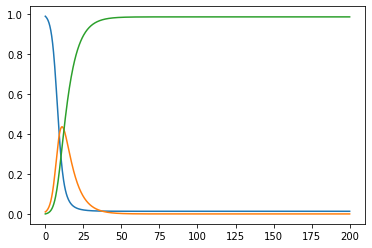

In [41]:
# Plot of true solution 

plt.plot(b070_g016_i001[0], b070_g016_i001[1])
plt.plot(b070_g016_i001[0], b070_g016_i001[2])
plt.plot(b070_g016_i001[0], b070_g016_i001[3])


In [84]:
r4_da100_de100 = sir_pinn(epochs=10,data= b070_g016_i001_train, c0 = b070_g016_i001_C0)
r4_da010_de100 = sir_pinn(epochs=10,data= b070_g016_i001_train[:,:10], c0 = b070_g016_i001_C0) 
r4_da010_de000 = sir_neural_net(epochs=10,data= b070_g016_i001_train[:,:10], c0 = b070_g016_i001_C0)
r4_da000_de100 = sir_pinn_fixed_p(epochs=10, data= b070_g016_i001_train, c0 =b070_g016_i001_C0, beta = 0.70, gamma=0.16)

### R4 "Many" datapoints and "many" de-domain points.

###### r4_da100_de100 10 epochs Run #######
Epoch 0, training loss: 0.049188338220119476, beta_param: tensor([-0.8197], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.0158], grad_fn=<TanhBackward0>)
Epoch 1, training loss: 0.019172053784132004, beta_param: tensor([-0.7596], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.0609], grad_fn=<TanhBackward0>)
Epoch 2, training loss: 0.009220635518431664, beta_param: tensor([-0.6656], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.1694], grad_fn=<TanhBackward0>)
Epoch 3, training loss: 0.005865296348929405, beta_param: tensor([-0.5891], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.1216], grad_fn=<TanhBackward0>)
Epoch 4, training loss: 0.004484332632273436, beta_param: tensor([-0.5061], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.0874], grad_fn=<TanhBackward0>)
Epoch 5, training loss: 0.003714753082022071, beta_param: tensor([-0.4155], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.0659], grad_fn=<TanhBackward0>)
Epoch 6,

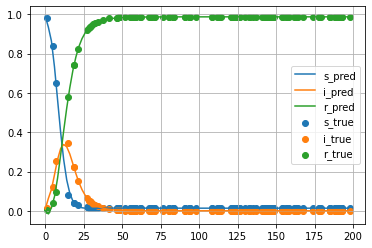

In [43]:
print('###### r4_da100_de100 10 epochs Run #######')
r4_da100_de100.adam_train()
print(f'Test loss {test_loss(r4_da100_de100,b070_g016_i001_test)}')

###### r4_da100_de100 TUS Run #######
Epoch 0, training loss: 0.001108628581278026, beta_param: tensor([0.0729], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0378], grad_fn=<TanhBackward0>)
Epoch 1, training loss: 0.0007829406531527638, beta_param: tensor([0.1587], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0593], grad_fn=<TanhBackward0>)
Epoch 2, training loss: 0.0005332644795998931, beta_param: tensor([0.2371], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0793], grad_fn=<TanhBackward0>)
Epoch 3, training loss: 0.0003509031084831804, beta_param: tensor([0.3078], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0973], grad_fn=<TanhBackward0>)
Epoch 4, training loss: 0.00022477643506135792, beta_param: tensor([0.3709], grad_fn=<TanhBackward0>), gamma_param: tensor([0.1125], grad_fn=<TanhBackward0>)
Epoch 5, training loss: 0.00014014499902259558, beta_param: tensor([0.4269], grad_fn=<TanhBackward0>), gamma_param: tensor([0.1245], grad_fn=<TanhBackward0>)
Epoch 6, training l

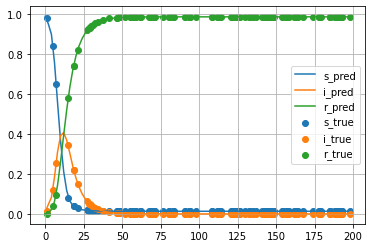

In [44]:
print('###### r4_da100_de100 TUS Run #######') 
r4_da100_de100.adam_train()
print(f'Test loss {test_loss(r4_da100_de100,b070_g016_i001_test)}')

### R4 "Few" datapoints and "many" de-domain points.


###### r4_da010_de100 10 epochs Run #######
Epoch 0, training loss: 35.39291000366211, beta_param: tensor([0.7175], grad_fn=<TanhBackward0>), gamma_param: tensor([0.9525], grad_fn=<TanhBackward0>)
Epoch 1, training loss: 20.878807067871094, beta_param: tensor([0.6741], grad_fn=<TanhBackward0>), gamma_param: tensor([0.9519], grad_fn=<TanhBackward0>)
Epoch 2, training loss: 12.260516166687012, beta_param: tensor([0.6119], grad_fn=<TanhBackward0>), gamma_param: tensor([0.9504], grad_fn=<TanhBackward0>)
Epoch 3, training loss: 6.534079551696777, beta_param: tensor([0.5049], grad_fn=<TanhBackward0>), gamma_param: tensor([0.9469], grad_fn=<TanhBackward0>)
Epoch 4, training loss: 2.9524827003479004, beta_param: tensor([0.3831], grad_fn=<TanhBackward0>), gamma_param: tensor([0.9301], grad_fn=<TanhBackward0>)
Epoch 5, training loss: 1.0211869478225708, beta_param: tensor([0.2546], grad_fn=<TanhBackward0>), gamma_param: tensor([0.9040], grad_fn=<TanhBackward0>)
Epoch 6, training loss: 0.23517367

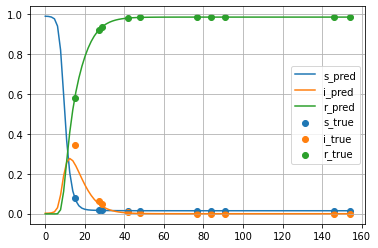

In [45]:
print('###### r4_da010_de100 10 epochs Run #######')
r4_da010_de100.adam_train()
print(f'Test loss {test_loss(r4_da010_de100,b070_g016_i001_test)}')

###### r4_da010_de100 TUS Run #######
Epoch 0, training loss: 0.00036934996023774147, beta_param: tensor([0.0646], grad_fn=<TanhBackward0>), gamma_param: tensor([0.1868], grad_fn=<TanhBackward0>)
Epoch 1, training loss: 0.0003008520870935172, beta_param: tensor([0.0613], grad_fn=<TanhBackward0>), gamma_param: tensor([0.1787], grad_fn=<TanhBackward0>)
Epoch 2, training loss: 0.0002343236410524696, beta_param: tensor([0.0589], grad_fn=<TanhBackward0>), gamma_param: tensor([0.1724], grad_fn=<TanhBackward0>)
Epoch 3, training loss: 0.00017480712267570198, beta_param: tensor([0.0569], grad_fn=<TanhBackward0>), gamma_param: tensor([0.1669], grad_fn=<TanhBackward0>)
Epoch 4, training loss: 0.00013061596837360412, beta_param: tensor([0.0554], grad_fn=<TanhBackward0>), gamma_param: tensor([0.1626], grad_fn=<TanhBackward0>)
Epoch 5, training loss: 9.84819998848252e-05, beta_param: tensor([0.0542], grad_fn=<TanhBackward0>), gamma_param: tensor([0.1593], grad_fn=<TanhBackward0>)
Epoch 6, training 

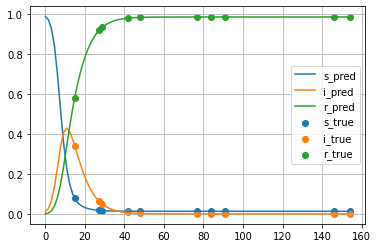

In [76]:
print('###### r4_da010_de100 TUS Run #######') 
r4_da010_de100.adam_train()
print(f'Test loss {test_loss(r4_da010_de100,b070_g016_i001_test)}')

### R4 "Few" datapoints only 


###### r4_da010_de000 10 epochs Run #######
Epoch 0, training loss: 0.18457219004631042
Epoch 1, training loss: 0.011432523839175701
Epoch 2, training loss: 0.0013387302169576287
Epoch 3, training loss: 0.0007054907619021833
Epoch 4, training loss: 0.00046060539898462594
Epoch 5, training loss: 0.0002883424749597907
Epoch 6, training loss: 0.00018045221804641187
Epoch 7, training loss: 0.00010570406448096037
Epoch 8, training loss: 6.291699537541717e-05
Epoch 9, training loss: 4.079325299244374e-05
Test loss 1.750573754310608


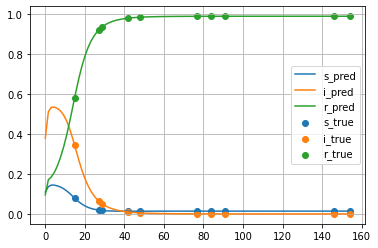

In [85]:
print('###### r4_da010_de000 10 epochs Run #######')
r4_da010_de000.adam_train()
print(f'Test loss {test_loss(r4_da010_de000,b070_g016_i001_test)}')

###### r4_da010_de000 TUS Run #######
Epoch 0, training loss: 1.623087229063458e-07
Epoch 1, training loss: 1.983409418926385e-07
Epoch 2, training loss: 1.587387288282116e-07
Epoch 3, training loss: 1.56943428919476e-07
Epoch 4, training loss: 1.5522847718330013e-07
Epoch 5, training loss: 4.001746560788888e-07
Epoch 6, training loss: 1.5154304833231436e-07
Epoch 7, training loss: 1.4970626693866507e-07
Epoch 8, training loss: 1.6888229765754659e-06
Epoch 9, training loss: 1.4597357278489653e-07
Test loss 0.005148867145180702


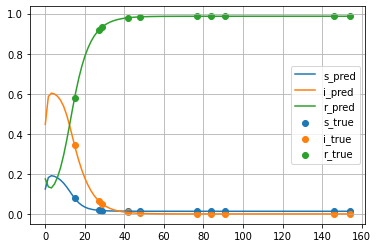

In [82]:
print('###### r4_da010_de000 TUS Run #######')
r4_da010_de000.adam_train()
print(f'Test loss {test_loss(r4_da010_de100,b070_g016_i001_test)}')

### R4 "Many" de-domain points only, and fixed parameters 



In [105]:
print('###### r4_da000_de100 10 epochs Run #######')
r4_da000_de100.adam_train()
print(f'Test loss {test_loss(r4_da000_de100,b070_g016_i001_test)}')


Test loss 1.7194565534591675


###### r3_da000_de100 TUS Run #######
Epoch 0, training loss: 6.745352038706187e-06
Epoch 1, training loss: 6.306757768470561e-06
Epoch 2, training loss: 5.851106834597886e-06
Epoch 3, training loss: 5.350177616492147e-06
Epoch 4, training loss: 4.837330379814375e-06
Epoch 5, training loss: 4.30694717579172e-06
Epoch 6, training loss: 3.832352831523167e-06
Epoch 7, training loss: 3.3913381685124477e-06
Epoch 8, training loss: 2.991428118548356e-06
Epoch 9, training loss: 2.626691184559604e-06
Test loss 1.9731149673461914


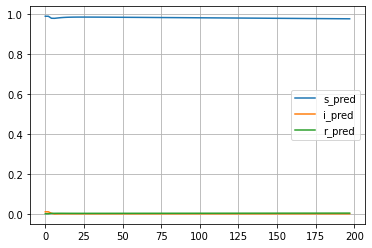

In [50]:
print('###### r4_da000_de100 TUS Run #######')
r4_da000_de100.adam_train()
print(f'Test loss {test_loss(r4_da000_de100,b070_g016_i001_test)}')

#  Round 5

Parameters:

N = 1,

I0 = 0.20,

S0= 0.80 

$\beta$ = 0.70
$\gamma$ = 0.16


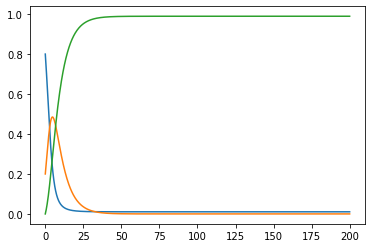

In [51]:
## True solution plot
plt.plot(b070_g016_i020[0], b070_g016_i020[1])
plt.plot(b070_g016_i020[0], b070_g016_i020[2])
plt.plot(b070_g016_i020[0], b070_g016_i020[3])

In [52]:
r5_da100_de100 = sir_pinn(epochs=10,data= b070_g016_i020_train, c0 = b070_g016_i020_C0)
r5_da010_de100 = sir_pinn(epochs=10,data= b070_g016_i020_train[:,:10], c0 = b070_g016_i001_C0) 
r5_da010_de000 = sir_neural_net(epochs=10,data= b070_g016_i020_train[:,:10], c0 = b070_g016_i020_C0)
r5_da000_de100 = sir_pinn_fixed_p(epochs=10, data= b070_g016_i020_train, c0 = b070_g016_i020_C0, beta = 0.70, gamma=0.16)

### R5 "Many" datapoints and "many" de-domain points.

###### r5_da100_de100 10 epochs Run #######
Epoch 0, training loss: 0.03464139252901077, beta_param: tensor([0.6610], grad_fn=<TanhBackward0>), gamma_param: tensor([0.6038], grad_fn=<TanhBackward0>)
Epoch 1, training loss: 0.014895853586494923, beta_param: tensor([0.5857], grad_fn=<TanhBackward0>), gamma_param: tensor([0.5286], grad_fn=<TanhBackward0>)
Epoch 2, training loss: 0.0047080316580832005, beta_param: tensor([0.5185], grad_fn=<TanhBackward0>), gamma_param: tensor([0.3973], grad_fn=<TanhBackward0>)
Epoch 3, training loss: 0.0018755875062197447, beta_param: tensor([0.4445], grad_fn=<TanhBackward0>), gamma_param: tensor([0.2999], grad_fn=<TanhBackward0>)
Epoch 4, training loss: 0.000692593224812299, beta_param: tensor([0.3728], grad_fn=<TanhBackward0>), gamma_param: tensor([0.2306], grad_fn=<TanhBackward0>)
Epoch 5, training loss: 0.00019776892440859228, beta_param: tensor([0.3157], grad_fn=<TanhBackward0>), gamma_param: tensor([0.1854], grad_fn=<TanhBackward0>)
Epoch 6, training

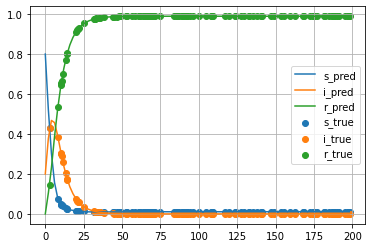

In [53]:
print('###### r5_da100_de100 10 epochs Run #######')
r5_da100_de100.adam_train()
print(f'Test loss {test_loss(r5_da100_de100,b070_g016_i020_test)}')

###### r5_da100_de100 TUS Run #######
Epoch 0, training loss: 5.217956982050964e-07, beta_param: tensor([0.2969], grad_fn=<TanhBackward0>), gamma_param: tensor([0.1596], grad_fn=<TanhBackward0>)
Epoch 1, training loss: 1.0301748432084423e-07, beta_param: tensor([0.2972], grad_fn=<TanhBackward0>), gamma_param: tensor([0.1596], grad_fn=<TanhBackward0>)
Epoch 2, training loss: 9.084313035145897e-08, beta_param: tensor([0.2975], grad_fn=<TanhBackward0>), gamma_param: tensor([0.1597], grad_fn=<TanhBackward0>)
Epoch 3, training loss: 8.088328229405306e-08, beta_param: tensor([0.2976], grad_fn=<TanhBackward0>), gamma_param: tensor([0.1597], grad_fn=<TanhBackward0>)
Epoch 4, training loss: 7.122989842400784e-08, beta_param: tensor([0.2978], grad_fn=<TanhBackward0>), gamma_param: tensor([0.1597], grad_fn=<TanhBackward0>)
Epoch 5, training loss: 7.831700941096642e-07, beta_param: tensor([0.2979], grad_fn=<TanhBackward0>), gamma_param: tensor([0.1597], grad_fn=<TanhBackward0>)
Epoch 6, training l

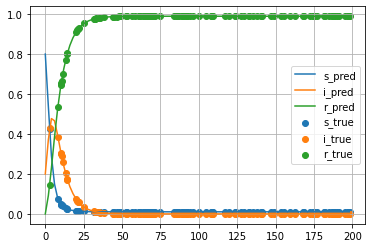

In [86]:
print('###### r5_da100_de100 TUS Run #######') 
r5_da100_de100.adam_train()
print(f'Test loss {test_loss(r5_da100_de100,b070_g016_i020_test)}')

### R5 "Few" datapoints and "many" de-domain points.

###### r5_da010_de100 10 epochs Run #######
Epoch 0, training loss: 1490.3902587890625, beta_param: tensor([0.9705], grad_fn=<TanhBackward0>), gamma_param: tensor([0.1029], grad_fn=<TanhBackward0>)
Epoch 1, training loss: 1376.5848388671875, beta_param: tensor([0.9698], grad_fn=<TanhBackward0>), gamma_param: tensor([0.1596], grad_fn=<TanhBackward0>)
Epoch 2, training loss: 1284.7593994140625, beta_param: tensor([0.9684], grad_fn=<TanhBackward0>), gamma_param: tensor([0.2444], grad_fn=<TanhBackward0>)
Epoch 3, training loss: 1199.8800048828125, beta_param: tensor([0.9657], grad_fn=<TanhBackward0>), gamma_param: tensor([0.3394], grad_fn=<TanhBackward0>)
Epoch 4, training loss: 1119.1943359375, beta_param: tensor([0.9598], grad_fn=<TanhBackward0>), gamma_param: tensor([0.4290], grad_fn=<TanhBackward0>)
Epoch 5, training loss: 1041.874267578125, beta_param: tensor([0.9502], grad_fn=<TanhBackward0>), gamma_param: tensor([0.5080], grad_fn=<TanhBackward0>)
Epoch 6, training loss: 967.60272216

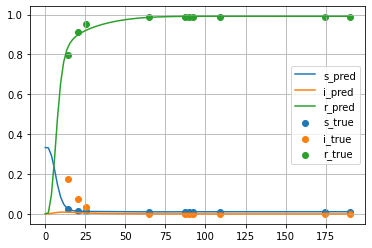

In [55]:
print('###### r5_da010_de100 10 epochs Run #######')
r5_da010_de100.adam_train()
print(f'Test loss {test_loss(r5_da010_de100,b070_g016_i020_test)}')

###### r5_da010_de100 TUS Run #######
Epoch 0, training loss: 18.24491310119629, beta_param: tensor([0.0307], grad_fn=<TanhBackward0>), gamma_param: tensor([0.2580], grad_fn=<TanhBackward0>)
Epoch 1, training loss: 11.072196960449219, beta_param: tensor([0.0296], grad_fn=<TanhBackward0>), gamma_param: tensor([0.2525], grad_fn=<TanhBackward0>)
Epoch 2, training loss: 5.955987930297852, beta_param: tensor([0.0287], grad_fn=<TanhBackward0>), gamma_param: tensor([0.2491], grad_fn=<TanhBackward0>)
Epoch 3, training loss: 2.6699881553649902, beta_param: tensor([0.0278], grad_fn=<TanhBackward0>), gamma_param: tensor([0.2445], grad_fn=<TanhBackward0>)
Epoch 4, training loss: 0.8933087587356567, beta_param: tensor([0.0267], grad_fn=<TanhBackward0>), gamma_param: tensor([0.2369], grad_fn=<TanhBackward0>)
Epoch 5, training loss: 0.18170273303985596, beta_param: tensor([0.0251], grad_fn=<TanhBackward0>), gamma_param: tensor([0.2244], grad_fn=<TanhBackward0>)
Epoch 6, training loss: 0.0162563882768

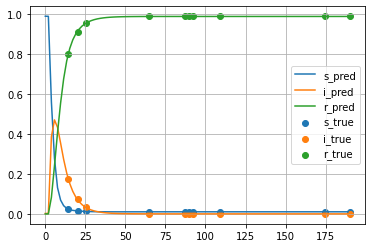

In [88]:
print('###### r5_da010_de100 TUS Run #######') 
r5_da010_de100.adam_train()
print(f'Test loss {test_loss(r5_da010_de100,b070_g016_i020_test)}')

### R5 "Few" datapoints only 

###### r5_da010_de000 10 epochs Run #######
Epoch 0, training loss: 0.05548423156142235
Epoch 1, training loss: 0.0014514189679175615
Epoch 2, training loss: 0.0002937563695013523
Epoch 3, training loss: 0.00012017779954476282
Epoch 4, training loss: 8.483664714731276e-05
Epoch 5, training loss: 6.415913230739534e-05
Epoch 6, training loss: 4.725430699181743e-05
Epoch 7, training loss: 3.295005080872215e-05
Epoch 8, training loss: 2.432429391774349e-05
Epoch 9, training loss: 1.21524290079833e-05
Test loss 15.5285005569458


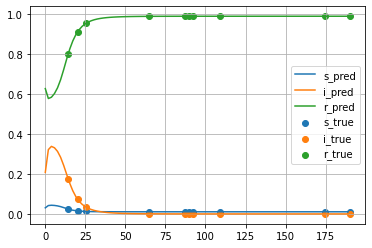

In [57]:
print('###### r5_da010_de000 10 epochs Run #######')
r5_da010_de000.adam_train()
print(f'Test loss {test_loss(r5_da010_de000,b070_g016_i020_test)}')

###### r5_da010_de000 TUS Run #######
Epoch 0, training loss: 3.2207140066020656e-07
Epoch 1, training loss: 3.147894176436239e-07
Epoch 2, training loss: 8.687194394951803e-07
Epoch 3, training loss: 2.577228883637872e-07
Epoch 4, training loss: 2.409756234555971e-07
Epoch 5, training loss: 2.2765632934351743e-07
Epoch 6, training loss: 2.1346579615055816e-07
Epoch 7, training loss: 2.0865785188561858e-07
Epoch 8, training loss: 1.934667750447261e-07
Epoch 9, training loss: 5.019408035877859e-06
Test loss 16.73634910583496


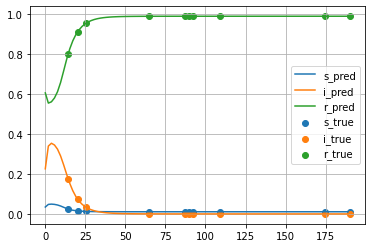

In [89]:
print('###### r5_da010_de000 TUS Run #######')
r5_da010_de000.adam_train()
print(f'Test loss {test_loss(r5_da010_de100,b070_g016_i020_test)}')

### R5 "Many" de-domain points only, and fixed parameters 

###### r5_da000_de100 10 epochs Run #######
Epoch 0, training loss: 0.014842810109257698
Epoch 1, training loss: 0.013279986567795277
Epoch 2, training loss: 0.012489616870880127
Epoch 3, training loss: 0.01206283364444971
Epoch 4, training loss: 0.011595796793699265
Epoch 5, training loss: 0.009845104068517685
Epoch 6, training loss: 0.0019043051870539784
Epoch 7, training loss: 0.00023028944269753993
Epoch 8, training loss: 6.376811506925151e-05
Epoch 9, training loss: 1.8720427760854363e-05
Test loss 0.009948130697011948


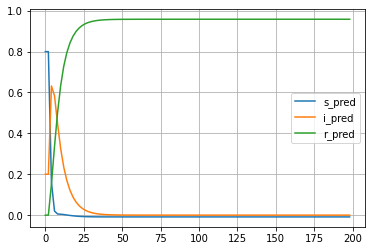

In [59]:
print('###### r5_da000_de100 10 epochs Run #######')
r5_da000_de100.adam_train()
print(f'Test loss {test_loss(r5_da000_de100,b070_g016_i020_test)}')

###### r5_da000_de100 TUS Run #######
Epoch 0, training loss: 5.780185801995685e-06
Epoch 1, training loss: 2.1791506696899887e-06
Epoch 2, training loss: 1.0794598210850381e-06
Epoch 3, training loss: 5.889312433282612e-07
Epoch 4, training loss: 3.413467482005217e-07
Epoch 5, training loss: 2.2349804851273802e-07
Epoch 6, training loss: 1.7400998331140727e-07
Epoch 7, training loss: 1.6143846437444154e-07
Epoch 8, training loss: 1.4148504590139055e-07
Epoch 9, training loss: 1.3527383657674363e-07
Test loss 0.008653855882585049


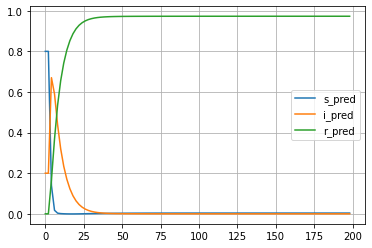

In [60]:

print('###### r5_da000_de100 TUS Run #######')
r5_da000_de100.adam_train()
print(f'Test loss {test_loss(r5_da000_de100,b070_g016_i020_test)}')

## Parameter discovery on noisy data. 

In [8]:
b020_g005_i020n070 = genfromtxt('Data/SIR_generated/b020_g005_i020n070', delimiter=',').T
b020_g005_i020n070_train, b020_g005_i020n070_test = sampling(b020_g005_i020n070)
b020_g005_i020n070_C0 = b020_g005_i020n070[1:][:,0]


## Round 6

$\beta$ = 0.20

$\gamma$ = 0.05

$N = 1$

$S_0 = 0.80$

$I_0 = 0.20$

$noise = 0.7\sigma$



In [35]:
r6_da100_de100 = sir_pinn(epochs=10,data= b020_g005_i020n070_train, c0 =b020_g005_i020n070_C0)
r6_da010_de100 = sir_pinn(epochs=10,data= b020_g005_i020n070_train[:,:10], c0 = b020_g005_i020n070_C0) 

### 100 Data-points 100De-points

###### r6_da100_de100 10 epochs Run #######
Epoch 0, training loss: 0.07572975754737854, beta_param: tensor([-0.5952], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.6436], grad_fn=<TanhBackward0>)
Epoch 1, training loss: 0.04573618620634079, beta_param: tensor([-0.6324], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.5849], grad_fn=<TanhBackward0>)
Epoch 2, training loss: 0.03675632178783417, beta_param: tensor([-0.6499], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.5096], grad_fn=<TanhBackward0>)
Epoch 3, training loss: 0.02923448011279106, beta_param: tensor([-0.6284], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.4291], grad_fn=<TanhBackward0>)
Epoch 4, training loss: 0.022576991468667984, beta_param: tensor([-0.5630], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.3457], grad_fn=<TanhBackward0>)
Epoch 5, training loss: 0.016991715878248215, beta_param: tensor([-0.4697], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.2626], grad_fn=<TanhBackward0>)
Epoch 6, tra

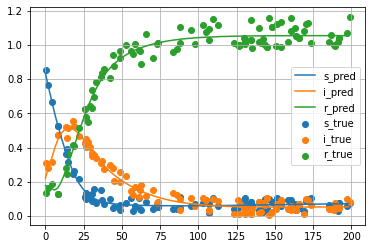

In [36]:
print('###### r6_da100_de100 10 epochs Run #######')
r6_da100_de100.adam_train()
print(f'Test loss {test_loss(r6_da100_de100,b020_g005_i020n070_test)}')

###### r6_da100_de100 TUS Run #######
Epoch 0, training loss: 0.005678133107721806, beta_param: tensor([0.1381], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0432], grad_fn=<TanhBackward0>)
Epoch 1, training loss: 0.005674240179359913, beta_param: tensor([0.1379], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0432], grad_fn=<TanhBackward0>)
Epoch 2, training loss: 0.0056681339628994465, beta_param: tensor([0.1378], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0432], grad_fn=<TanhBackward0>)
Epoch 3, training loss: 0.0056622629053890705, beta_param: tensor([0.1376], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0432], grad_fn=<TanhBackward0>)
Epoch 4, training loss: 0.005655334331095219, beta_param: tensor([0.1374], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0432], grad_fn=<TanhBackward0>)
Epoch 5, training loss: 0.005646265111863613, beta_param: tensor([0.1371], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0432], grad_fn=<TanhBackward0>)
Epoch 6, training loss: 

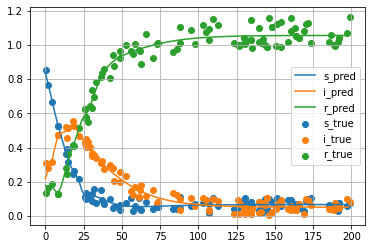

In [16]:
print('###### r6_da100_de100 TUS Run #######')
r6_da100_de100.adam_train()
print(f'Test loss {test_loss(r6_da100_de100,b020_g005_i020n070_test)}')

### 10 Data-points 100De-points

###### r6_da100_de100 10 epochs Run #######
Epoch 0, training loss: 0.17365360260009766, beta_param: tensor([0.8958], grad_fn=<TanhBackward0>), gamma_param: tensor([0.8441], grad_fn=<TanhBackward0>)
Epoch 1, training loss: 0.09226198494434357, beta_param: tensor([0.8568], grad_fn=<TanhBackward0>), gamma_param: tensor([0.8104], grad_fn=<TanhBackward0>)
Epoch 2, training loss: 0.0793011412024498, beta_param: tensor([0.8205], grad_fn=<TanhBackward0>), gamma_param: tensor([0.7664], grad_fn=<TanhBackward0>)
Epoch 3, training loss: 0.06323158740997314, beta_param: tensor([0.7808], grad_fn=<TanhBackward0>), gamma_param: tensor([0.7164], grad_fn=<TanhBackward0>)
Epoch 4, training loss: 0.04952041804790497, beta_param: tensor([0.7362], grad_fn=<TanhBackward0>), gamma_param: tensor([0.6606], grad_fn=<TanhBackward0>)
Epoch 5, training loss: 0.03996080532670021, beta_param: tensor([0.6843], grad_fn=<TanhBackward0>), gamma_param: tensor([0.5971], grad_fn=<TanhBackward0>)
Epoch 6, training loss: 0.0

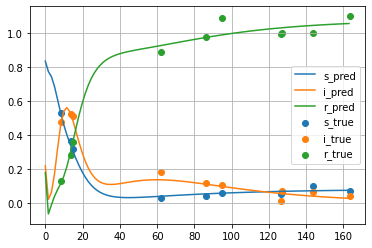

In [17]:
print('###### r6_da100_de100 10 epochs Run #######')
r6_da010_de100.adam_train()
print(f'Test loss {test_loss(r6_da010_de100,b020_g005_i020n070_test)}')

###### r6_da100_de100 TUS Run #######
Epoch 0, training loss: 0.0029710540547966957, beta_param: tensor([0.0738], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0402], grad_fn=<TanhBackward0>)
Epoch 1, training loss: 0.0029670963995158672, beta_param: tensor([0.0735], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0405], grad_fn=<TanhBackward0>)
Epoch 2, training loss: 0.002962238620966673, beta_param: tensor([0.0733], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0407], grad_fn=<TanhBackward0>)
Epoch 3, training loss: 0.002954247407615185, beta_param: tensor([0.0730], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0408], grad_fn=<TanhBackward0>)
Epoch 4, training loss: 0.00295014469884336, beta_param: tensor([0.0728], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0408], grad_fn=<TanhBackward0>)
Epoch 5, training loss: 0.002946254564449191, beta_param: tensor([0.0725], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0407], grad_fn=<TanhBackward0>)
Epoch 6, training loss: 0

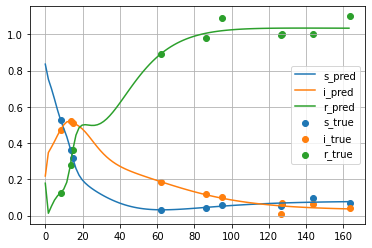

In [19]:
print('###### r6_da010_de100 TUS Run #######')
r6_da010_de100.adam_train()
print(f'Test loss {test_loss(r6_da010_de100,b020_g005_i020n070_test)}')

In [37]:
r6_da010_de1000 = sir_pinn(epochs=10,data= b020_g005_i020n070_train[:,:10], c0 = b020_g005_i020n070_C0, nde= 1000) 

###### r6_da010_de1000 10 epochs Run #######
Epoch 0, training loss: 0.20945364236831665, beta_param: tensor([0.6120], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.4002], grad_fn=<TanhBackward0>)
Epoch 1, training loss: 0.07997635006904602, beta_param: tensor([0.5068], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.2969], grad_fn=<TanhBackward0>)
Epoch 2, training loss: 0.045799434185028076, beta_param: tensor([0.4229], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.2016], grad_fn=<TanhBackward0>)
Epoch 3, training loss: 0.02479398064315319, beta_param: tensor([0.3467], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.1170], grad_fn=<TanhBackward0>)
Epoch 4, training loss: 0.012544238939881325, beta_param: tensor([0.2748], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.0428], grad_fn=<TanhBackward0>)
Epoch 5, training loss: 0.006331323646008968, beta_param: tensor([0.2084], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0163], grad_fn=<TanhBackward0>)
Epoch 6, training

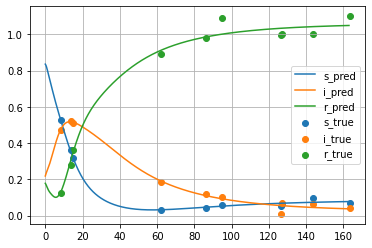

In [38]:
print('###### r6_da010_de1000 10 epochs Run #######')
r6_da010_de1000.adam_train()
print(f'Test loss {test_loss(r6_da010_de1000,b020_g005_i020n070_test)}')



###### r6_da010_de1000 TUS Run #######
Epoch 0, training loss: 0.003004111349582672, beta_param: tensor([0.0831], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0388], grad_fn=<TanhBackward0>)
Epoch 1, training loss: 0.0029967688024044037, beta_param: tensor([0.0833], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0389], grad_fn=<TanhBackward0>)
Epoch 2, training loss: 0.0029915475752204657, beta_param: tensor([0.0835], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0389], grad_fn=<TanhBackward0>)
Epoch 3, training loss: 0.0029854262247681618, beta_param: tensor([0.0836], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0389], grad_fn=<TanhBackward0>)
Epoch 4, training loss: 0.002980737714096904, beta_param: tensor([0.0837], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0389], grad_fn=<TanhBackward0>)
Epoch 5, training loss: 0.0029763176571577787, beta_param: tensor([0.0838], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0389], grad_fn=<TanhBackward0>)
Epoch 6, training los

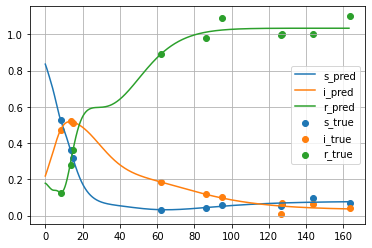

In [40]:
print('###### r6_da010_de1000 TUS Run #######')
r6_da010_de1000.adam_train()
print(f'Test loss {test_loss(r6_da010_de1000,b020_g005_i020n070_test)}')

## Round 7

$\beta$ = 0.20

$\gamma$ = 0.05

$N = 1$

$S_0 = 0.80$

$I_0 = 0.20$

$noise = 1.4\sigma$


In [20]:
b020_g005_i020n140 = genfromtxt('Data/SIR_generated/b020_g005_i020n140', delimiter=',').T
b020_g005_i020n140_train, b020_g005_i020n140_test = sampling(b020_g005_i020n140)
b020_g005_i020n140_C0 = b020_g005_i020n140[1:][:,0]

In [21]:
r7_da100_de100 = sir_pinn(epochs=10,data= b020_g005_i020n140_train, c0 =b020_g005_i020n140_C0)
r7_da010_de100 = sir_pinn(epochs=10,data= b020_g005_i020n140_train[:,:10], c0 = b020_g005_i020n140_C0) 

### 100Da-points 100De-points

###### r6_da100_de100 10 epochs Run #######
Epoch 0, training loss: 0.08876417577266693, beta_param: tensor([0.8370], grad_fn=<TanhBackward0>), gamma_param: tensor([0.7069], grad_fn=<TanhBackward0>)
Epoch 1, training loss: 0.05536031723022461, beta_param: tensor([0.8534], grad_fn=<TanhBackward0>), gamma_param: tensor([0.6424], grad_fn=<TanhBackward0>)
Epoch 2, training loss: 0.04698806256055832, beta_param: tensor([0.8566], grad_fn=<TanhBackward0>), gamma_param: tensor([0.5707], grad_fn=<TanhBackward0>)
Epoch 3, training loss: 0.04083921015262604, beta_param: tensor([0.8311], grad_fn=<TanhBackward0>), gamma_param: tensor([0.4948], grad_fn=<TanhBackward0>)
Epoch 4, training loss: 0.03528439253568649, beta_param: tensor([0.7794], grad_fn=<TanhBackward0>), gamma_param: tensor([0.4160], grad_fn=<TanhBackward0>)
Epoch 5, training loss: 0.03060283325612545, beta_param: tensor([0.7149], grad_fn=<TanhBackward0>), gamma_param: tensor([0.3377], grad_fn=<TanhBackward0>)
Epoch 6, training loss: 0.

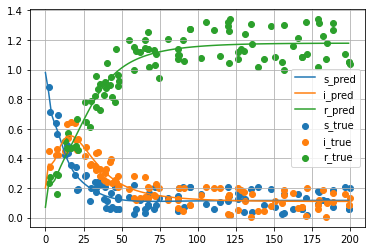

In [22]:
print('###### r7_da100_de100 10 epochs Run #######')
r7_da100_de100.adam_train()
print(f'Test loss {test_loss(r7_da100_de100,b020_g005_i020n140_test)}')

###### r6_da100_de100 TUS Run #######
Epoch 0, training loss: 0.01880071312189102, beta_param: tensor([0.0927], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0337], grad_fn=<TanhBackward0>)
Epoch 1, training loss: 0.01877456158399582, beta_param: tensor([0.0929], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0337], grad_fn=<TanhBackward0>)
Epoch 2, training loss: 0.018739329650998116, beta_param: tensor([0.0933], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0337], grad_fn=<TanhBackward0>)
Epoch 3, training loss: 0.01870579458773136, beta_param: tensor([0.0937], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0337], grad_fn=<TanhBackward0>)
Epoch 4, training loss: 0.018685946241021156, beta_param: tensor([0.0934], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0335], grad_fn=<TanhBackward0>)
Epoch 5, training loss: 0.01867266558110714, beta_param: tensor([0.0926], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0333], grad_fn=<TanhBackward0>)
Epoch 6, training loss: 0.0186

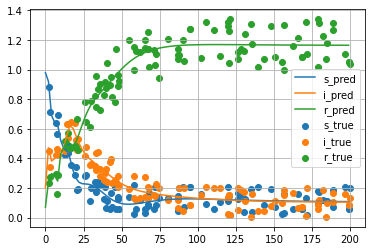

In [25]:
print('###### r7_da100_de100 TUS Run #######')
r7_da100_de100.adam_train()
print(f'Test loss {test_loss(r7_da100_de100,b020_g005_i020n140_test)}')

### 10 Da-points 100De-points

###### r7_da100_de100 10 epochs Run #######
Epoch 0, training loss: 0.9208993315696716, beta_param: tensor([0.6336], grad_fn=<TanhBackward0>), gamma_param: tensor([0.2584], grad_fn=<TanhBackward0>)
Epoch 1, training loss: 0.29633772373199463, beta_param: tensor([0.5464], grad_fn=<TanhBackward0>), gamma_param: tensor([0.2419], grad_fn=<TanhBackward0>)
Epoch 2, training loss: 0.23593677580356598, beta_param: tensor([0.4551], grad_fn=<TanhBackward0>), gamma_param: tensor([0.2151], grad_fn=<TanhBackward0>)
Epoch 3, training loss: 0.18827170133590698, beta_param: tensor([0.3562], grad_fn=<TanhBackward0>), gamma_param: tensor([0.1690], grad_fn=<TanhBackward0>)
Epoch 4, training loss: 0.15493978559970856, beta_param: tensor([0.2571], grad_fn=<TanhBackward0>), gamma_param: tensor([0.1245], grad_fn=<TanhBackward0>)
Epoch 5, training loss: 0.132103830575943, beta_param: tensor([0.1654], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0921], grad_fn=<TanhBackward0>)
Epoch 6, training loss: 0.120

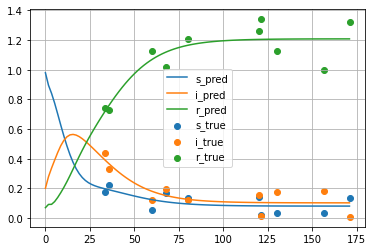

In [26]:
print('###### r7_da010_de100 10 epochs Run #######')
r7_da010_de100.adam_train()
print(f'Test loss {test_loss(r7_da010_de100,b020_g005_i020n140_test)}')

###### r7_da010_de100 TUS Run #######
Epoch 0, training loss: 0.028896303847432137, beta_param: tensor([0.0169], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0292], grad_fn=<TanhBackward0>)
Epoch 1, training loss: 0.028615666553378105, beta_param: tensor([0.0168], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0291], grad_fn=<TanhBackward0>)
Epoch 2, training loss: 0.028393762186169624, beta_param: tensor([0.0168], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0290], grad_fn=<TanhBackward0>)
Epoch 3, training loss: 0.030488966032862663, beta_param: tensor([0.0167], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0288], grad_fn=<TanhBackward0>)
Epoch 4, training loss: 0.028060322627425194, beta_param: tensor([0.0165], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0286], grad_fn=<TanhBackward0>)
Epoch 5, training loss: 0.027963940054178238, beta_param: tensor([0.0163], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0284], grad_fn=<TanhBackward0>)
Epoch 6, training loss: 0.

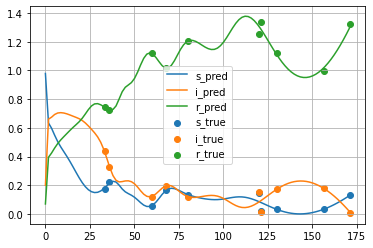

In [29]:
print('###### r7_da010_de100 TUS Run #######')
r7_da010_de100.adam_train()
print(f'Test loss {test_loss(r7_da010_de100,b020_g005_i020n140_test)}')

### 10 Da-points 1000De-points

In [31]:
#r7_da100_de1000 = sir_pinn(epochs=10,data= b020_g005_i020n140_train, c0 =b020_g005_i020n140_C0, nde=1000)
r7_da010_de1000 = sir_pinn(epochs=10,data= b020_g005_i020n140_train[:,:10], c0 = b020_g005_i020n140_C0, nde= 1000) 

###### r7_da010_de1000 10 epochs Run #######
Epoch 0, training loss: 0.8799666166305542, beta_param: tensor([-0.0292], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.5756], grad_fn=<TanhBackward0>)
Epoch 1, training loss: 0.24008381366729736, beta_param: tensor([0.0040], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.4813], grad_fn=<TanhBackward0>)
Epoch 2, training loss: 0.1749860793352127, beta_param: tensor([0.0038], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.3806], grad_fn=<TanhBackward0>)
Epoch 3, training loss: 0.14866246283054352, beta_param: tensor([0.0063], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.2804], grad_fn=<TanhBackward0>)
Epoch 4, training loss: 0.13217060267925262, beta_param: tensor([0.0131], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.1920], grad_fn=<TanhBackward0>)
Epoch 5, training loss: 0.12216197699308395, beta_param: tensor([0.0201], grad_fn=<TanhBackward0>), gamma_param: tensor([-0.1108], grad_fn=<TanhBackward0>)
Epoch 6, training lo

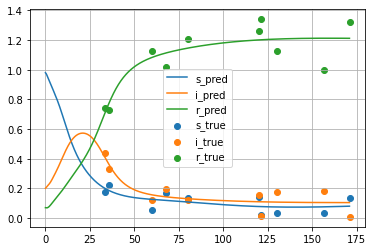

In [32]:
print('###### r7_da010_de1000 10 epochs Run #######')
r7_da010_de1000.adam_train()
print(f'Test loss {test_loss(r7_da010_de1000,b020_g005_i020n140_test)}')

###### r7_da010_de1000 TUS Run #######
Epoch 0, training loss: 0.049472056329250336, beta_param: tensor([0.0268], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0421], grad_fn=<TanhBackward0>)
Epoch 1, training loss: 0.04330161213874817, beta_param: tensor([0.0263], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0415], grad_fn=<TanhBackward0>)
Epoch 2, training loss: 0.04153423383831978, beta_param: tensor([0.0257], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0409], grad_fn=<TanhBackward0>)
Epoch 3, training loss: 0.04013964161276817, beta_param: tensor([0.0252], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0404], grad_fn=<TanhBackward0>)
Epoch 4, training loss: 0.03893676772713661, beta_param: tensor([0.0249], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0400], grad_fn=<TanhBackward0>)
Epoch 5, training loss: 0.037772320210933685, beta_param: tensor([0.0246], grad_fn=<TanhBackward0>), gamma_param: tensor([0.0397], grad_fn=<TanhBackward0>)
Epoch 6, training loss: 0.036

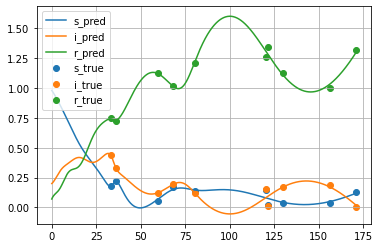

In [34]:
print('###### r7_da010_de1000 TUS Run #######')
r7_da010_de1000.adam_train()
print(f'Test loss {test_loss(r7_da010_de1000,b020_g005_i020n140_test)}')